#### Covid-19 detection using CNN and transfer-learning techniques on Chest X-Ray Images. 

**Research question**

Which Convolutional Neural Network (CNN) architecture for Machine Learning is the most efficient at 
classifying Chest X-Ray images for Covid-19 patients?

### 1. Libraries import and setup

In [1]:
import matplotlib.pyplot as plt
import numpy as np
import os
import pandas as pd
import seaborn as sns
import tensorflow as tf

# from sklearn.metrics import confusion_matrix, classification_report
from sklearn.model_selection import train_test_split
from keras.preprocessing.image import ImageDataGenerator

import constants as CONSTANTS
import utilities as UTILS
from enums import (
  CollectionType,
  LabelType,
  ModelType
)
import models as MODELS

UTILS.detect_GPU()

✅ GPU detected


### 2. Loading dataset/s

In [2]:
def loadRadiographyDataDictionary():
  def _getFolderName(labelType):
    return {
      LabelType.COVID: "COVID",
      LabelType.NORMAL: "Normal",
      LabelType.PNEUMONIA: "Viral Pneumonia"
    }[labelType]

  def _toModel(labelType):
    metadata = pd.read_excel(CONSTANTS.DATASET_RADIOGRAPHY_ROOT + "/" + _getFolderName(labelType) + ".metadata.xlsx")
    images = []

    for i in range(metadata.shape[0]):
      images.append(CONSTANTS.DATASET_RADIOGRAPHY_ROOT + "/" + _getFolderName(labelType) + "/" + metadata["FILE NAME"].iloc[i] + ".png")

    df_result = pd.DataFrame(images, columns=["image"])
    df_result["label"] = labelType.value

    return df_result

  return {
    LabelType.COVID: _toModel(LabelType.COVID),
    LabelType.NORMAL: _toModel(LabelType.NORMAL),
    LabelType.PNEUMONIA: _toModel(LabelType.PNEUMONIA)
  }

# radiography_data_dict = loadRadiographyDataDictionary()
# radiography_df = flatten_dataframes_dictionary(radiography_data_dict)
# radiography_df.shape[0]
# radiography_df.sample(10)

In [3]:
def loadChestDataDictionary():
  def _getFolderName(labelType):
    return {
      LabelType.COVID: "COVID19",
      LabelType.NORMAL: "NORMAL",
      LabelType.PNEUMONIA: "PNEUMONIA"
    }[labelType]

  def _toModel(labelType):
    images = []

    def _loadCollectionProcedure(collectionType):
      for dirname, _, filenames in os.walk(CONSTANTS.DATASET_CHEST_ROOT + "/" + collectionType.value + "/" + _getFolderName(labelType)):
        for filename in filenames:
          images.append(os.path.join(dirname, filename))

    _loadCollectionProcedure(CollectionType.TEST)
    _loadCollectionProcedure(CollectionType.TRAIN)

    df_result = pd.DataFrame(images, columns=["image"])
    df_result["label"] = labelType.value

    return df_result

  return {
    LabelType.COVID: _toModel(LabelType.COVID),
    LabelType.NORMAL: _toModel(LabelType.NORMAL),
    LabelType.PNEUMONIA: _toModel(LabelType.PNEUMONIA)
  }

# chest_data_dict = loadChestDataDictionary()
# chest_df = flatten_dataframes_dictionary(chest_data_dict)
# chest_df.shape[0]
# chest_df.sample(10)

In [4]:
chest_data_dict = loadChestDataDictionary()
chest_df = UTILS.flatten_dataframes_dictionary(chest_data_dict)
# del chest_data_dict, chest_df

print("Chest dataset:")
print(chest_df["label"].value_counts())

Chest dataset:
pneumonia    4273
normal       1583
covid         576
Name: label, dtype: int64


In [5]:
radiography_data_dict = loadRadiographyDataDictionary()
radiography_df = UTILS.flatten_dataframes_dictionary(radiography_data_dict)
# del radiography_data_dict, radiography_df

print("Radiography dataset:")
print(radiography_df["label"].value_counts())

Radiography dataset:
normal       10192
covid         3616
pneumonia     1345
Name: label, dtype: int64


In [6]:
source_dict = UTILS.merge_dataframe_dictionaries(chest_data_dict, radiography_data_dict)

# Balance data labels
UTILS.min_count_balance_data_dict(source_dict)

source_df = UTILS.flatten_dataframes_dictionary(source_dict)

print("Source dataset:")
print(source_df["label"].value_counts())

Source dataset:
covid        4192
normal       4192
pneumonia    4192
Name: label, dtype: int64


### 3. Dataset analysis

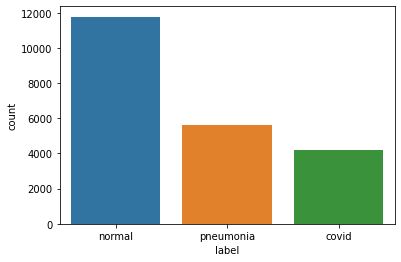

In [7]:
unbalanced_data_dict = UTILS.merge_dataframe_dictionaries(chest_data_dict, radiography_data_dict)
unbalanced_data_df = UTILS.flatten_dataframes_dictionary(unbalanced_data_dict)

sns.countplot(data=unbalanced_data_df, x="label", order=unbalanced_data_df.label.value_counts().index)
del unbalanced_data_dict, unbalanced_data_df

<AxesSubplot:xlabel='label', ylabel='count'>

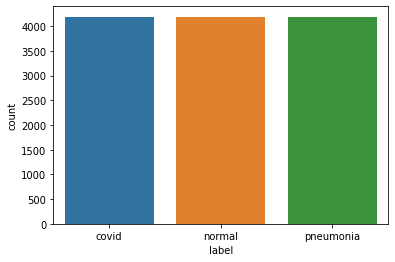

In [8]:
sns.countplot(data=source_df, x="label", order=source_df.label.value_counts().index)

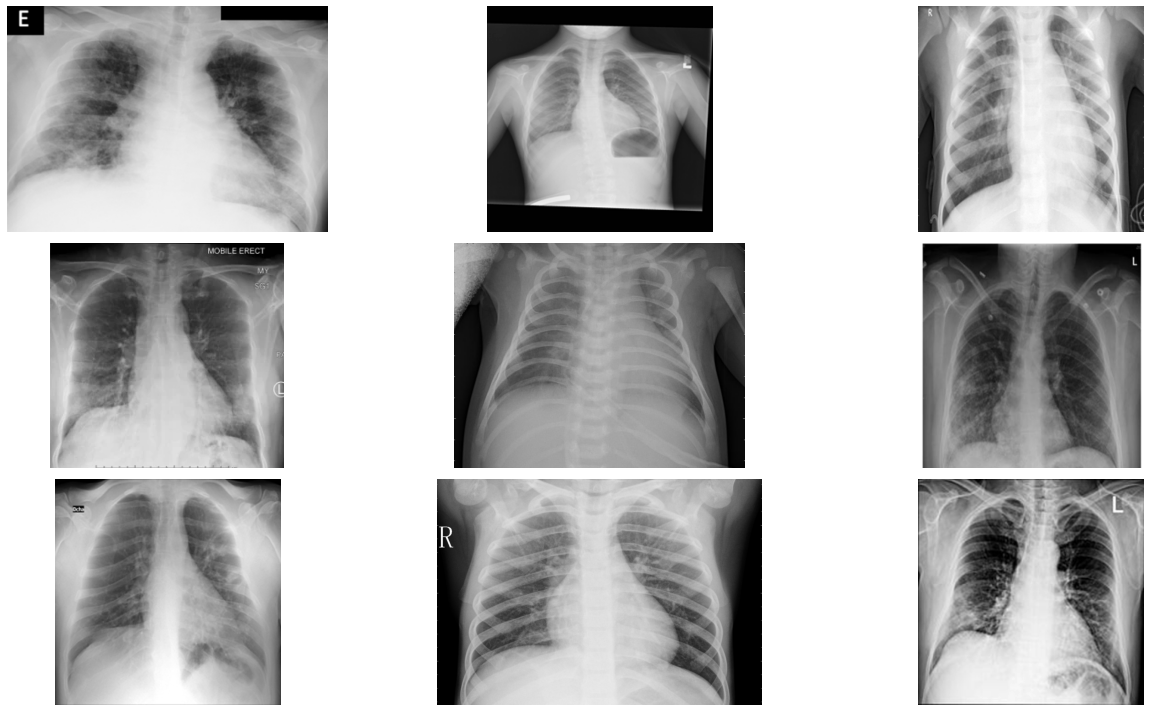

In [9]:
image_samples = list(source_df.sample(9)["image"]) 

plt.figure(figsize=(20, 10))

for i, sample in zip(range(9), image_samples):
    plt.subplot(3, 3, i + 1)
    img = plt.imread(sample)
    plt.imshow(img, cmap="gray")
    plt.axis("off")
    
plt.tight_layout()


The dimensions of the image are 643 pixels width and 913 pixels height, one single color channel.
The maximum pixel value is 1.0000 and the minimum is 0.0000
The mean value of the pixels is 0.6550 and the standard deviation is 0.2326


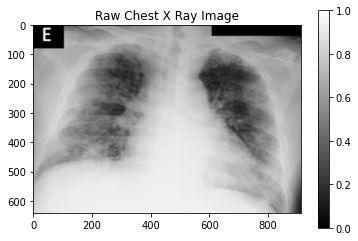

In [10]:
sample_img = plt.imread(image_samples[0])
plt.imshow(sample_img, cmap="gray")
plt.colorbar()
plt.title("Raw Chest X Ray Image")

print(f"The dimensions of the image are {sample_img.shape[0]} pixels width and {sample_img.shape[1]} pixels height, one single color channel.")
print(f"The maximum pixel value is {sample_img.max():.4f} and the minimum is {sample_img.min():.4f}")
print(f"The mean value of the pixels is {sample_img.mean():.4f} and the standard deviation is {sample_img.std():.4f}")

C:\tools\python\lib\site-packages\seaborn\distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


Text(0, 0.5, '# Pixels in Image')

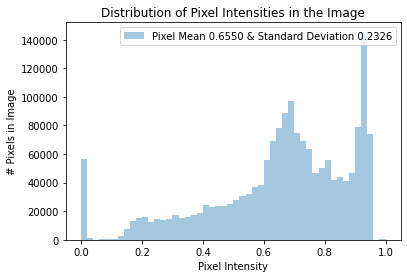

In [11]:
sns.distplot(sample_img.ravel(),
  label=f"Pixel Mean {np.mean(sample_img):.4f} & Standard Deviation {np.std(sample_img):.4f}", 
  kde=False)
plt.legend(loc="upper right")
plt.title("Distribution of Pixel Intensities in the Image")
plt.xlabel("Pixel Intensity")
plt.ylabel("# Pixels in Image")

### 4. Model building

In [12]:
x_train, x_test, y_train, y_test = train_test_split(
  source_df["image"],
  source_df["label"],
  test_size=CONSTANTS.TEST_SPLIT_SIZE,
  random_state=42
)

train_df = pd.DataFrame({ "image_path": x_train, "label": y_train })
test_df = pd.DataFrame({ "image_path": x_test, "label": y_test })

In [13]:
train_generator = ImageDataGenerator(CONSTANTS.TRAIN_IMAGE_GEN_OPTIONS).flow_from_dataframe(
  train_df,
  x_col="image_path",
  y_col="label",
  target_size=(256, 256),
  batch_size=24,
  shuffle=True,
  class_mode="sparse",
  validate_filenames=True
)

test_generator = ImageDataGenerator(CONSTANTS.TEST_IMAGE_GEN_OPTIONS).flow_from_dataframe(
  test_df,
  x_col="image_path",
  y_col="label",
  target_size=(256, 256),
  batch_size=24,
  shuffle=False,
  class_mode="sparse",
  validate_filenames=True
)

Found 10060 validated image filenames belonging to 3 classes.
Found 2516 validated image filenames belonging to 3 classes.


In [14]:
# try:
#   del chest_data_dict, chest_df
# except:
#   print("Chest dataset not found")

# try:
#   del radiography_data_dict, radiography_df
# except:
#   print("Radiography dataset not found")

# try:
#   del source_dict, source_df
# except:
#   print("Source dataset not found")

In [15]:
%load_ext tensorboard

##### Compile

In [16]:
deep_covid_model = MODELS.get(ModelType.DEEP_COVID)

opt = tf.keras.optimizers.Adam(learning_rate = 1e-3)

deep_covid_model.compile(
  optimizer=opt,
  loss="sparse_categorical_crossentropy",
  metrics=["accuracy"]
)

##### Train

[RAM optimisation stack overflow](https://stackoverflow.com/questions/53683164/keras-occupies-an-indefinitely-increasing-amount-of-memory-for-each-epoch)

In [17]:
deep_covid_model.fit_generator(
  train_generator,
  epochs=1,
  validation_data=test_generator,
  verbose=1,
  callbacks=[UTILS.get_tensorboard_callback(ModelType.DEEP_COVID)]
)

C:\Users\barka\AppData\Local\Temp\ipykernel_11176\3869113719.py:1: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  deep_covid_model.fit_generator(
C:\tools\python\lib\site-packages\keras_preprocessing\image\image_data_generator.py:720: UserWarning: This ImageDataGenerator specifies `featurewise_center`, but it hasn't been fit on any training data. Fit it first by calling `.fit(numpy_data)`.
  warnings.warn('This ImageDataGenerator specifies '


420/420 [==============================] - 229s 538ms/step - loss: 0.5115 - accuracy: 0.7944 - val_loss: 0.2975 - val_accuracy: 0.8847


In [18]:
# plt.imshow(train_generator.next())

In [26]:
deep_covid_model.save("modelsave.h5", save_format="tf")

In [27]:
# deep_covid_model.build(input_shape=(256, 256))
from keras.models import load_model

newmodel = load_model("modelsave.h5")

# deep_covid_model2 = MODELS.get(ModelType.DEEP_COVID)

# opt = tf.keras.optimizers.Adam(learning_rate = 1e-3)

# deep_covid_model2.compile(
#   optimizer=opt,
#   loss="sparse_categorical_crossentropy",
#   metrics=["accuracy"]
# )
# deep_covid_model2.load_weights("./" + ModelType.DEEP_COVID.value + ".h5")

ValueError: Input has undefined `axis` dimension. Received input with shape (None, None, None, None). Axis value: ListWrapper([3])

In [ ]:
from keras.preprocessing.image import load_img
from keras.preprocessing.image import img_to_array

sample = source_df.sample(1)

image_path = sample["image"].iloc[0]
image_label = sample["label"].iloc[0]

print(f'True value is : {image_label}')

image = load_img(image_path, target_size=(256, 256))
img = img_to_array(image)
img = img.reshape((1, 256, 256, 3))

result = deep_covid_model.predict(img)
print('Prediction is:', result)
result = np.argmax(result, axis=-1)
print('Prediction is:', result)
    # covid, normal, pneumonia
plt.imshow(image) 

In [29]:
deep_covid_model2 = MODELS.get(ModelType.DEEP_COVID)
deep_covid_model2.load_weights("modelsave.h5")
# opt = tf.keras.optimizers.Adam(learning_rate = 1e-3)

# deep_covid_model.compile(
#   optimizer=opt,
#   loss="sparse_categorical_crossentropy",
#   metrics=["accuracy"]
# )

ValueError: Unable to load weights saved in HDF5 format into a subclassed Model which has not created its variables yet. Call the Model first, then load the weights.